In [1]:
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt

##### Path generation using the Euler-Maruyama method

The Heston process can be discretized using the Euler-Maruyama method 

In the next cell I present the algorithm that produces sample paths of the Heston process. In this example, I prefer to use the log-variables $X_t = \log(S_t)$ and $Y_t = \log(v_t)$ in order to avoid negative values for the process $\{v_t\}_{t\geq 0}$.    

$$ \begin{cases}
dX_t= dlog(S_t) = \biggl( \mu - \frac{1}{2} e^{Y_t} \biggr) dt + e^{Y_t/2} dW^1_t \\
dY_t = dlog(v_t)= e^{-Y_t} \biggl[ \kappa (\theta - e^{Y_t}) - \frac{1}{2}\sigma^2 \biggr] dt + \sigma e^{-Y_t/2} dW^2_t 
\end{cases}$$


In [39]:
%%time
np.random.seed(seed=42) 

N = 91                 # time steps 
paths = 3              # number of paths
T = 1
T_vec, dt = np.linspace(0, T, N, retstep=True )
dt_sq = np.sqrt(dt)

CPU times: user 220 µs, sys: 51 µs, total: 271 µs
Wall time: 283 µs


In [40]:
S0 = 100          # spot price
X0 = np.log(S0)   # log price
v0 = 0.06         # spot variance
Y0 = np.log(v0)   # log-variance 

mu = 0.01                                          # drift
rho = -0.4                                         # correlation coefficient
kappa = 3                                          # mean reversion coefficient
theta = 0.05                                       # long-term variance
sigma = 0.1                                        # Vol of Vol - Volatility of instantaneous variance
std_asy = np.sqrt( theta * sigma**2 /(2*kappa) )   # asymptotic standard deviation for the CIR process

assert(2*kappa * theta > sigma**2)                 # Feller condition

In [41]:
# Generate random Brownian Motion
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
W = ss.multivariate_normal.rvs( mean=MU, cov=COV, size=(paths,N-1) )

W_S = W[:,:,0]   # Stock Brownian motion:     W_1
W_v = W[:,:,1]   # Variance Brownian motion:  W_2


In [42]:
# Initialize vectors
Y = np.zeros((paths,N))
Y[:,0] = Y0 # log-variance  
X = np.zeros((paths,N))
X[:,0] = X0  # log-stock
v = np.zeros(N)

In [45]:
# Generate paths
for t in range(0,N-1):
    v = np.exp(Y[:,t])    # variance 
    v_sq = np.sqrt(v)     # square root of variance 
    

    Y[:,t+1] = Y[:,t] + (1/v)*( kappa*(theta - v) - 0.5*sigma**2 )*dt + sigma * (1/v_sq) * dt_sq * W_v[:,t]   
    X[:,t+1] = X[:,t] + (mu - 0.5*v)*dt + v_sq * dt_sq * W_S[:,t]

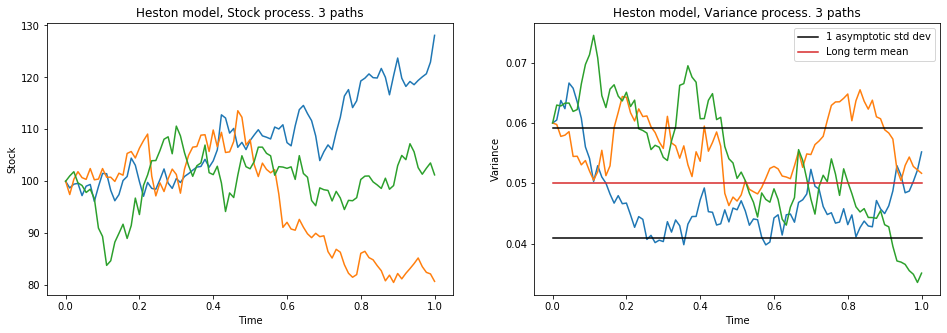

In [46]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(T_vec, np.exp(X.T) )
ax1.set_title("Heston model, Stock process. 3 paths"); ax1.set_xlabel("Time"); ax1.set_ylabel("Stock")
ax2.plot(T_vec, np.exp(Y.T) )
ax2.set_title("Heston model, Variance process. 3 paths"); ax2.set_xlabel("Time"); ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
ax2.plot(T_vec, (theta - std_asy)*np.ones_like(T_vec), color="black" )
ax2.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean" )
ax2.legend(loc="upper right"); 
plt.show()

##### Path generation using Milstein Scheme

The Heston process can be discretized using the Milstein Scheme

   

$$ \begin{cases}
dX_t= dlog(S_t) = \biggl( \mu - \frac{1}{2} e^{Y_t} \biggr) dt + e^{Y_t/2} dW^1_t \\
dY_t = dlog(v_t)= \biggl[ \kappa (\theta - e^{Y_t}) - \frac{1}{4}\sigma^2 \biggr] dt + \biggl( e^{Y_t/2}+ \frac{1}{2}\sigma dW^2_t \biggr)^2
\end{cases}$$


In [47]:
# Initialize vectors
S0 = 100          # spot price
X0 = np.log(S0)   # log price
v0 = 0.06         # spot variance
Y0 = np.log(v0) 
Y = np.zeros((paths,N))
Y[:,0] = Y0 # log-variance  
X = np.zeros((paths,N))
X[:,0] = X0  # log-stock
v = np.zeros(N)

# Generate paths
for t in range(0,N-1):
    v = np.exp(Y[:,t])    # variance 
    v_sq = np.sqrt(v)     # square root of variance 
    Y[:,t+1] = Y[:,t] + (kappa*(theta - v) - 0.25*sigma**2)*dt + (
        v_sq + 0.5* sigma * dt*W_v[:,t])**2
    X[:,t+1] = X[:,t] + (mu - 0.5*v)*dt + v_sq * dt_sq * W_S[:,t]

/Users/sani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/Users/sani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in add
/Users/sani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in add


/Users/sani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


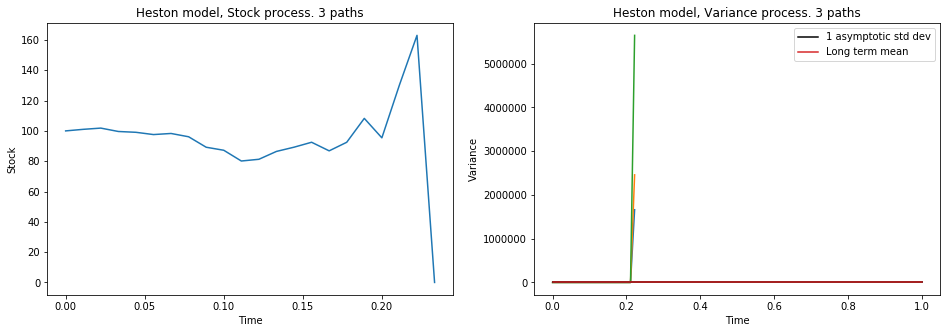

In [49]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(T_vec, np.exp(X[2,:]))
ax1.set_title("Heston model, Stock process. 3 paths"); ax1.set_xlabel("Time"); ax1.set_ylabel("Stock")
ax2.plot(T_vec, np.exp(Y.T) )
ax2.set_title("Heston model, Variance process. 3 paths"); ax2.set_xlabel("Time"); ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
ax2.plot(T_vec, (theta - std_asy)*np.ones_like(T_vec), color="black" )
ax2.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean" )
ax2.legend(loc="upper right"); 
plt.show()